# Introduction

The following notebook it aimed at quantifying the movement of CDR domains in TCR variable regions between unbound (*apo*) and bound (*holo*) conformations of *in silico* structures. The *holo* conforomations in this case are TCRs bound to class I pMHC complexes.

In [2]:
import glob
import os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from python_pdb.aligners import align_sequences, align
from python_pdb.comparisons import rmsd
from python_pdb.entities import Structure
from python_pdb.parsers import parse_pdb
from python_pdb.formats.pdb import (ALT_LOC_RANGE, ATOM_NAME_RANGE, ATOM_NUMBER_RANGE, B_FACTOR_RANGE,
                                                     CHAIN_ID_RANGE, CHARGE_RANGE, ELEMENT_RANGE, INSERT_CODE_RANGE,
                                                     OCCUPANCY_RANGE, RESIDUE_NAME_RANGE, SEQ_ID_RANGE, X_POS_RANGE,
                                                     Y_POS_RANGE, Z_POS_RANGE)
from python_pdb.formats.residue import THREE_TO_ONE_CODE

In [3]:
TCRMODEL2_STRUCTURES_PATH = '/project/koohylab/bmcmaste/data/TCRModel2-tcrs/data'
export_path = '../data/apo-holo-mhc-class-I-synthetic'

In [16]:
tcrmodel_2_structures = pd.DataFrame(glob.glob('**/ranked_0.pdb', root_dir=TCRMODEL2_STRUCTURES_PATH, recursive=True), columns=['path'])

tcrmodel_2_structures['form'] = tcrmodel_2_structures['path'].map(lambda path: path.split('/')[0])
tcrmodel_2_structures['pdb_id'] = tcrmodel_2_structures['path'].map(lambda path: path.split('/')[1].split('_')[0])
tcrmodel_2_structures['state'] = tcrmodel_2_structures['form'].map(lambda form: 'apo' if form == 'unbound' else 'holo')

tcrmodel_2_structures

,path,form,pdb_id,state
0,unbound/6uk2_DE/ranked_0.pdb,unbound,6uk2,apo
1,unbound/4iiq_AB/ranked_0.pdb,unbound,4iiq,apo
2,unbound/5wjo_CD/ranked_0.pdb,unbound,5wjo,apo
3,unbound/3qh3_AB/ranked_0.pdb,unbound,3qh3,apo
4,unbound/3mff_AB/ranked_0.pdb,unbound,3mff,apo
...,...,...,...,...
472,mhcI/7r80_ABEC/ranked_0.pdb,mhcI,7r80,holo
473,mhcI/5c0b_IJHF/ranked_0.pdb,mhcI,5c0b,holo
474,mhcI/5hhm_DECA/ranked_0.pdb,mhcI,5hhm,holo
475,mhcI/1nam_ABPH/ranked_0.pdb,mhcI,1nam,holo


## Annotating sequences

Here, the peptide sequence of the alpha chain and beta chain, and if applicable, peptide and MHC complex are collected. These sequences will be used to group similar TCRs.

In [9]:
AHO_CDR1 = set(range(20, 47 + 1))
AHO_CDR2 = set(range(51, 82 + 1))
AHO_CDR3 = set(range(102, 144 + 1))

def assign_cdr(seq_id):
    if seq_id in AHO_CDR1:
        return 1
    
    if seq_id in AHO_CDR2:
        return 2
    
    if seq_id in AHO_CDR3:
        return 3
    
    return None

In [17]:
cdr_1_alpha_seq = []
cdr_2_alpha_seq = []
cdr_3_alpha_seq = []

cdr_1_beta_seq = []
cdr_2_beta_seq = []
cdr_3_beta_seq = []

peptide_seq = []

mhc_chain_1_seq = []
mhc_chain_2_seq = []


for index, entry in tcrmodel_2_structures.iterrows():
    with open(os.path.join(TCRMODEL2_STRUCTURES_PATH, entry['path']), 'r') as fh:
            structure = parse_pdb(fh.read(), silent=True)
    
    structure_df = structure.to_pandas()

    structure_df['cdr'] = structure_df['residue_seq_id'].map(lambda id_: assign_cdr(id_))
    structure_df['res_olc'] = structure_df['residue_name'].map(lambda res_name: THREE_TO_ONE_CODE[res_name] if res_name in THREE_TO_ONE_CODE else None)

    # Alpha CDRs
    cdr_1_alpha_seq.append(''.join(structure_df.query(f"cdr == 1 & chain_id == 'D'")
                                               .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                               .dropna()))
    cdr_2_alpha_seq.append(''.join(structure_df.query(f"cdr == 2 & chain_id == 'D'")
                                               .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                               .dropna()))
    cdr_3_alpha_seq.append(''.join(structure_df.query(f"cdr == 3 & chain_id == 'D'")
                                               .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                               .dropna()))
    # Beta CDRs
    cdr_1_beta_seq.append(''.join(structure_df.query(f"cdr == 1 & chain_id == 'E'")
                                              .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                              .dropna()))
    cdr_2_beta_seq.append(''.join(structure_df.query(f"cdr == 2 & chain_id == 'E'")
                                              .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                              .dropna()))
    cdr_3_beta_seq.append(''.join(structure_df.query(f"cdr == 3 & chain_id == 'E'")
                                              .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                              .dropna()))
    if entry['form'] == 'mhcI':
        peptide_seq.append(''.join(structure_df.query(f"chain_id == 'C'")
                                               .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                               .dropna())
             )
        
        mhc_chain_1_seq.append(''.join(structure_df.query(f"chain_id == 'A'")
                                                   .drop_duplicates(['residue_seq_id', 'residue_insert_code'])['res_olc']
                                                   .dropna())
             )
    
        

    else:
        peptide_seq.append(None)
        mhc_chain_1_seq.append(None)
        mhc_chain_2_seq.append(None)

tcrmodel_2_structures['cdr_1_alpha_seq'] = cdr_1_alpha_seq
tcrmodel_2_structures['cdr_2_alpha_seq'] = cdr_2_alpha_seq
tcrmodel_2_structures['cdr_3_alpha_seq'] = cdr_3_alpha_seq

tcrmodel_2_structures['cdr_1_beta_seq'] = cdr_1_beta_seq
tcrmodel_2_structures['cdr_2_beta_seq'] = cdr_2_beta_seq
tcrmodel_2_structures['cdr_3_beta_seq'] = cdr_3_beta_seq

tcrmodel_2_structures['peptide_seq'] = peptide_seq

tcrmodel_2_structures['mhc_chain_1_seq'] = mhc_chain_1_seq

tcrmodel_2_structures

,path,form,pdb_id,state,cdr_1_alpha_seq,cdr_2_alpha_seq,cdr_3_alpha_seq,cdr_1_beta_seq,cdr_2_beta_seq,cdr_3_beta_seq,peptide_seq,mhc_chain_1_seq
0,unbound/6uk2_DE/ranked_0.pdb,unbound,6uk2,apo,TLSCTYDTSESDYYLFWYKQP,QMILVIRQEAYKQQNATENRFSVNF,AMYFCAFMDSNYQLIWGAGTK,TLRCKPISGHNSLFWYRQT,GLELLIYFNNNVPIDDSGMPEDRFSAKM,AVYFCASSRTSPTDTQYFGPGTR,None,None
1,unbound/4iiq_AB/ranked_0.pdb,unbound,4iiq,apo,QINCTYQTSGFNGLFWYQQH,APTFLSYNVLDGLEEKGRFSSFL,ASYLCAVKDSNYQLIWGAGTK,TLQCAQDMNHNSMYWYRQD,GLRLIYYSASEGTTDKGEVPNGYNVSR,SVYFCASSVWTGEGSGELFFGEGSR,None,None
2,unbound/5wjo_CD/ranked_0.pdb,unbound,5wjo,apo,NLPCNHSTISGNEYVYWYRQI,GPQYIIHGLKNNETNEMASLII,AVYYCIVRVAYRQKVTFGTGTK,ALRCDPISGHVSLFWYQQA,GPEFLTYFQNEAQLDKSGLPSDRFFAER,AVYLCASSLATGELFFGEGSR,None,None
3,unbound/3qh3_AB/ranked_0.pdb,unbound,3qh3,apo,SLNCTYSDRGSQSFFWYRQY,SPELIMSIYSNGDKEDGRFTAQL,ATYLCAVTTDSWGKLQFGAGTQ,TLQCAQDMNHEYMSWYRQD,GLRLIHYSVGAGITDQGEVPNGYNVSR,SVYFCASRPGLAGGRPEQYFGPGTR,None,None
4,unbound/3mff_AB/ranked_0.pdb,unbound,3mff,apo,ILNCSYENSAFDYFPWYQQF,GPALLIAIRSVSDKKEDGRFTIFF,ATYFCAATGANTGKLTFGHGTI,LLECGQDMSHETMYWYRQD,GLQLIYISYDVDSNSEGDIPKGYRVSR,SVYFCASSLAGTGNYEQYFGPGTR,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
472,mhcI/7r80_ABEC/ranked_0.pdb,mhcI,7r80,holo,VLNCSFTDSAIYNLQWFRQD,GLTSLLLIQSSQREQTSGRLNASL,ATYLCAQLNQAGTALIFGKGTT,TLQCAQDMNHEYMSWYRQD,GLRLIHYSVGAGITDQGEVPNGYNVSR,SVYFCASSYGTGINYGYTFGSGTR,QASQEVKNW,GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTE...
473,mhcI/5c0b_IJHF/ranked_0.pdb,mhcI,5c0b,holo,SLNCTYSNSAFQYFMWYRQY,GPELLMYTYSSGNKEDGRFTAQV,ATYLCAMRGDSSYKLIFGSGTR,TLRCKPISGHDYLFWYRQT,GLELLIYFNNNVPIDDSGMPEDRFSAKM,AVYFCASSLWEKLAKNIQYFGAGTR,RQFGPDFPTI,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...
474,mhcI/5hhm_DECA/ranked_0.pdb,mhcI,5hhm,holo,TVYCNSSSVFSSLQWYRQE,GPVLLVTVVTGGEVKKLKRLTFQF,GLYLCAGAGSQGNLIFGKGTK,TLSCEQNLNHDAMYWYRQD,GLRLIYYSQIVNDFQKGDIAEGYSVSR,AFYLCASSSRSSYEQYFGPGTR,GILGLVFTL,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...
475,mhcI/1nam_ABPH/ranked_0.pdb,mhcI,1nam,holo,TMDCVYETQDSSYFLFWYKQT,EIVFLIRQDSYKKENATVGHYSLNF,AVYFCAMRGDYGGSGNKLIFGTGTL,NLRCILKNSQYPWMSWYQQD,QLQWLFTLRSPGDKEVKSLPGADYLATR,RTLYCTCSADRVGNTLYFGEGSR,RGYVYQGL,GPHSLRYFVTAVSRPGLGEPRYMEVGYVDDTEFVRFDSDAENPRYE...


## Finding examples of TCRs with both *apo* and *holo* structures

Using the CDR sequences extracted in the last cell, group TCRs with the same sequence and drop the rest.

In [19]:
apo_holo_dfs = []

for sequences, tcr_group in tcrmodel_2_structures.groupby(['cdr_1_alpha_seq', 'cdr_2_alpha_seq', 'cdr_3_alpha_seq', 'cdr_1_beta_seq', 'cdr_2_beta_seq', 'cdr_3_beta_seq']):
    # Screen out groups that don't have apo and holo forms
    states = tcr_group['state'].unique().tolist()
    if 'apo' in states and 'holo' in states:
        tcr_group = tcr_group.copy()
        tcr_group['cdr_sequence_collated'] = '-'.join(sequences)
    
        apo_holo_dfs.append(tcr_group)

apo_holo_tcrs = pd.concat(apo_holo_dfs).reset_index(drop=True)
apo_holo_tcrs

,path,form,pdb_id,state,cdr_1_alpha_seq,cdr_2_alpha_seq,cdr_3_alpha_seq,cdr_1_beta_seq,cdr_2_beta_seq,cdr_3_beta_seq,peptide_seq,mhc_chain_1_seq,cdr_sequence_collated
0,unbound/6vth_DE/ranked_0.pdb,unbound,6vth,apo,AFNCTYSNSASQSFFWYRQD,EPKLLMSVYSSGNEDGRFTAQL,ATYLCVVQPGGYQKVTFGTGTK,TLQCAQDMNHNSMYWYRQD,GLRLIYYSASEGTTDKGEVPNGYNVSR,SVYFCASSEGLWQVGDEQYFGPGTR,None,None,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...
1,mhcI/6vrm_DEPA/ranked_0.pdb,mhcI,6vrm,holo,AFNCTYSNSASQSFFWYRQD,EPKLLMSVYSSGNEDGRFTAQL,ATYLCVVQPGGYQKVTFGTGTK,TLQCAQDMNHNSMYWYRQD,GLRLIYYSASEGTTDKGEVPNGYNVSR,SVYFCASSEGLWQVGDEQYFGPGTR,HMTEVVRHC,SHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEP...,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...
2,unbound/3skn_CD/ranked_0.pdb,unbound,3skn,apo,AFNCTYSNSASQSFFWYRQD,EPKLLMSVYSSGNEDGRFTAQL,ATYLCVVRAGKLIFGQGTE,TLLCAQDMNHEYMYWYRQD,GLRLIHYSVGEGTTAKGEVPDGYNVSR,SVYFCASGQGNFDIQYFGAGTR,None,None,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...
3,unbound/3skn_AB/ranked_0.pdb,unbound,3skn,apo,AFNCTYSNSASQSFFWYRQD,EPKLLMSVYSSGNEDGRFTAQL,ATYLCVVRAGKLIFGQGTE,TLLCAQDMNHEYMYWYRQD,GLRLIHYSVGEGTTAKGEVPDGYNVSR,SVYFCASGQGNFDIQYFGAGTR,None,None,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...
4,unbound/3skn_GH/ranked_0.pdb,unbound,3skn,apo,AFNCTYSNSASQSFFWYRQD,EPKLLMSVYSSGNEDGRFTAQL,ATYLCVVRAGKLIFGQGTE,TLLCAQDMNHEYMYWYRQD,GLRLIHYSVGEGTTAKGEVPDGYNVSR,SVYFCASGQGNFDIQYFGAGTR,None,None,AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-AT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,mhcI/2pye_DECA/ranked_0.pdb,mhcI,2pye,holo,VLNCSFTDSAIYNLQWFRQD,GLTSLLLIQSSQREQTSGRLNASL,ATYLCAVRPLLDGTYIPTFGRGTS,TLQCAQDMNHEYMSWYRQD,GLRLIHYSVGAGTTDQGEVPNGYNVSR,SVYFCASSYLGNTGELFFGEGSR,SLLMWITQC,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...
118,unbound/2bnu_AB/ranked_0.pdb,unbound,2bnu,apo,VLNCSFTDSAIYNLQWFRQD,GLTSLLLIQSSQREQTSGRLNASL,ATYLCAVRPTSGGSYIPTFGRGTS,TLQCAQDMNHEYMSWYRQD,GLRLIHYSVGAGITDQGEVPNGYNVSR,SVYFCASSYVGNTGELFFGEGSR,None,None,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...
119,mhcI/2bnr_DECA/ranked_0.pdb,mhcI,2bnr,holo,VLNCSFTDSAIYNLQWFRQD,GLTSLLLIQSSQREQTSGRLNASL,ATYLCAVRPTSGGSYIPTFGRGTS,TLQCAQDMNHEYMSWYRQD,GLRLIHYSVGAGITDQGEVPNGYNVSR,SVYFCASSYVGNTGELFFGEGSR,SLLMWITQC,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...
120,mhcI/6q3s_DECA/ranked_0.pdb,mhcI,6q3s,holo,VLNCSFTDSAIYNLQWFRQD,GLTSLLLIQSSQREQTSGRLNASL,ATYLCAVRPTSGGSYIPTFGRGTS,TLQCAQDMNHEYMSWYRQD,GLRLIHYSVGAGITDQGEVPNGYNVSR,SVYFCASSYVGNTGELFFGEGSR,SLLMWITQV,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,VLNCSFTDSAIYNLQWFRQD-GLTSLLLIQSSQREQTSGRLNASL-...


## Alignment

The next step is to align the same TCR (and pMHC if present) structures to the TCR framework regions (TCR variable domain not including the CDR loops) so that the comparisons can be computed using RMSD.

In [26]:
def get_sequence_from_df(df):
    df = df.copy()
    
    df = df[['chain_id', 'residue_name', 'residue_seq_id', 'residue_insert_code']]
    df = df.drop_duplicates()
    
    df['valid_res'] = df['residue_name'].map(lambda tlc: tlc in THREE_TO_ONE_CODE)
    df = df[df['valid_res']]
    
    seq = df['residue_name'].map(lambda tlc: THREE_TO_ONE_CODE[tlc]).tolist()
    
    return ''.join(seq)


for group_name, group in apo_holo_tcrs.groupby('cdr_sequence_collated'):
    output_path = os.path.join(export_path, group_name)
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    
    # Align on first entry
    reference_file = group.iloc[0]['path']

    with open(os.path.join(TCRMODEL2_STRUCTURES_PATH, reference_file), 'r') as fh:
        reference_structure = parse_pdb(fh.read(), silent=True)
    
    reference_structure_df = reference_structure.to_pandas()
    reference_structure_df = reference_structure_df.query("record_type == 'ATOM'")
    
    ref_alpha_chain_df = reference_structure_df.query(f"chain_id == 'D'").copy()
    ref_beta_chain_df = reference_structure_df.query(f"chain_id == 'E'").copy()
    
    ref_alpha_chain_df['cdr'] = ref_alpha_chain_df['residue_seq_id'].map(lambda id_: assign_cdr(id_))
    ref_beta_chain_df['cdr'] = ref_beta_chain_df['residue_seq_id'].map(lambda id_: assign_cdr(id_))
        
    ref_alpha_fw_df = ref_alpha_chain_df[ref_alpha_chain_df['cdr'].isna()]
    ref_beta_fw_df = ref_beta_chain_df[ref_beta_chain_df['cdr'].isna()]
    
    ref_alpha_fw_ca_df = ref_alpha_fw_df.query("atom_name == 'CA'")
    ref_beta_fw_ca_df = ref_beta_fw_df.query("atom_name == 'CA'")
    
    ref_alpha_chain_seq = get_sequence_from_df(ref_alpha_fw_df)
    ref_beta_chain_seq = get_sequence_from_df(ref_beta_fw_df)
    
    for path in group['path'].tolist():
        
        with open(os.path.join(TCRMODEL2_STRUCTURES_PATH, path), 'r') as fh:
            structure = parse_pdb(fh.read(), silent=True)
        
        structure_df = structure.to_pandas()
        structure_df = structure_df.query("record_type == 'ATOM'")
        
        alpha_chain = structure_df.query(f"chain_id == 'D'").copy()
        beta_chain = structure_df.query(f"chain_id == 'E'").copy()
        
        alpha_chain['cdr'] = alpha_chain['residue_seq_id'].map(lambda id_: assign_cdr(id_))
        beta_chain['cdr'] = beta_chain['residue_seq_id'].map(lambda id_: assign_cdr(id_))
    
        alpha_fw = alpha_chain[alpha_chain['cdr'].isna()]
        beta_fw = beta_chain[beta_chain['cdr'].isna()]
        
        alpha_fw_ca = alpha_fw.query("atom_name == 'CA'")
        beta_fw_ca = beta_fw.query("atom_name == 'CA'")
        
        alpha_chain_seq = get_sequence_from_df(alpha_fw)
        beta_chain_seq = get_sequence_from_df(beta_fw)
        
        alpha_alignment, _ = align_sequences(alpha_chain_seq, ref_alpha_chain_seq)
        beta_alignment, _ = align_sequences(beta_chain_seq, ref_beta_chain_seq)

        mobile_coords = []
        target_coords = []
        
        iter_mobile = alpha_fw_ca.itertuples()
        iter_target = ref_alpha_fw_ca_df.itertuples()
        
        for res_id_1, res_id_2 in alpha_alignment:
            next_res_1 = next(iter_mobile) if res_id_1 != '-' else None
            next_res_2 = next(iter_target) if res_id_2 != '-' else None

            if next_res_1 and next_res_2:
                mobile_coords.append((next_res_1.pos_x, next_res_1.pos_y, next_res_1.pos_z))
                target_coords.append((next_res_2.pos_x, next_res_2.pos_y, next_res_2.pos_z))
        
        iter_mobile = beta_fw_ca.itertuples()
        iter_target = ref_beta_fw_ca_df.itertuples()
        
        for res_id_1, res_id_2 in beta_alignment:
            next_res_1 = next(iter_mobile) if res_id_1 != '-' else None
            next_res_2 = next(iter_target) if res_id_2 != '-' else None

            if next_res_1 and next_res_2:
                mobile_coords.append((next_res_1.pos_x, next_res_1.pos_y, next_res_1.pos_z))
                target_coords.append((next_res_2.pos_x, next_res_2.pos_y, next_res_2.pos_z))

        mobile_coords = np.array(mobile_coords)
        target_coords = np.array(target_coords)
        
        aligned_structure = align(mobile_coords, target_coords, structure)
        
        with open(os.path.join(output_path, f"{path.split('/')[1]}.pdb"), 'w') as fh:
            fh.write(str(aligned_structure))


## Calculating RMSD between conformations

Now that the structures have been align, RMSD can be computed between all states of the same TCR. Comparions between the different *apo* and *holo* forms are also done so that these can be used as a control for the differences in *apo* to *holo* comparisons.

In [28]:
def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(export_path):
    pdb_files = [file for file in os.listdir(os.path.join(export_path, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        
        with open(os.path.join(export_path, group, path1), 'r') as fh:
            structure1_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        with open(os.path.join(export_path, group, path2), 'r') as fh:
            structure2_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        structure1_df['cdr'] = structure1_df['residue_seq_id'].map(assign_cdr_number)
        structure2_df['cdr'] = structure2_df['residue_seq_id'].map(assign_cdr_number)
        
        structure1_df['backbone'] = structure1_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))
        structure2_df['backbone'] = structure2_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))
        
        struct_1_cdr_1_alpha_backbone = structure1_df.query("cdr == 1 and chain_id == 'D' and backbone")
        struct_1_cdr_2_alpha_backbone = structure1_df.query("cdr == 2 and chain_id == 'D' and backbone")
        struct_1_cdr_3_alpha_backbone = structure1_df.query("cdr == 3 and chain_id == 'D' and backbone")
        
        struct_1_cdr_1_beta_backbone = structure1_df.query("cdr == 1 and chain_id == 'E' and backbone")
        struct_1_cdr_2_beta_backbone = structure1_df.query("cdr == 2 and chain_id == 'E' and backbone")
        struct_1_cdr_3_beta_backbone = structure1_df.query("cdr == 3 and chain_id == 'E' and backbone")
        
        struct_2_cdr_1_alpha_backbone = structure2_df.query("cdr == 1 and chain_id == 'D' and backbone")
        struct_2_cdr_2_alpha_backbone = structure2_df.query("cdr == 2 and chain_id == 'D' and backbone")
        struct_2_cdr_3_alpha_backbone = structure2_df.query("cdr == 3 and chain_id == 'D' and backbone")
        
        struct_2_cdr_1_beta_backbone = structure2_df.query("cdr == 1 and chain_id == 'E' and backbone")
        struct_2_cdr_2_beta_backbone = structure2_df.query("cdr == 2 and chain_id == 'E' and backbone")
        struct_2_cdr_3_beta_backbone = structure2_df.query("cdr == 3 and chain_id == 'E' and backbone")
        
        for _ in range(6):
            groups.append(group)
            struct1s.append(path1)
            struct2s.append(path2)
        
        for _ in range(3):
            chain_types.append('alpha')
        
        cdrs.append('CDR1')
        rmsds.append(rmsd(get_coords(struct_1_cdr_1_alpha_backbone), get_coords(struct_2_cdr_1_alpha_backbone)))
        cdrs.append('CDR2')
        rmsds.append(rmsd(get_coords(struct_1_cdr_2_alpha_backbone), get_coords(struct_2_cdr_2_alpha_backbone)))
        cdrs.append('CDR3')
        rmsds.append(rmsd(get_coords(struct_1_cdr_3_alpha_backbone), get_coords(struct_2_cdr_3_alpha_backbone)))
        
        for _ in range(3):
            chain_types.append('beta')
        
        cdrs.append('CDR1')
        rmsds.append(rmsd(get_coords(struct_1_cdr_1_beta_backbone), get_coords(struct_2_cdr_1_beta_backbone)))
        cdrs.append('CDR2')
        rmsds.append(rmsd(get_coords(struct_1_cdr_2_beta_backbone), get_coords(struct_2_cdr_2_beta_backbone)))
        cdrs.append('CDR3')
        rmsds.append(rmsd(get_coords(struct_1_cdr_3_beta_backbone), get_coords(struct_2_cdr_3_beta_backbone)))

5yxu_FG.pdb 5yxu_ABIC.pdb
6vrm_DEPA.pdb 6vth_DE.pdb
1mwa_ABPH.pdb 1g6r_CDQI.pdb
1mwa_ABPH.pdb 1mwa_CDQI.pdb
1mwa_ABPH.pdb 2ckb_ABPH.pdb
1mwa_ABPH.pdb 1tcr_AB.pdb
1mwa_ABPH.pdb 1g6r_ABPH.pdb
1mwa_ABPH.pdb 2ckb_CDQI.pdb
1g6r_CDQI.pdb 1mwa_CDQI.pdb
1g6r_CDQI.pdb 2ckb_ABPH.pdb
1g6r_CDQI.pdb 1tcr_AB.pdb
1g6r_CDQI.pdb 1g6r_ABPH.pdb
1g6r_CDQI.pdb 2ckb_CDQI.pdb
1mwa_CDQI.pdb 2ckb_ABPH.pdb
1mwa_CDQI.pdb 1tcr_AB.pdb
1mwa_CDQI.pdb 1g6r_ABPH.pdb
1mwa_CDQI.pdb 2ckb_CDQI.pdb
2ckb_ABPH.pdb 1tcr_AB.pdb
2ckb_ABPH.pdb 1g6r_ABPH.pdb
2ckb_ABPH.pdb 2ckb_CDQI.pdb
1tcr_AB.pdb 1g6r_ABPH.pdb
1tcr_AB.pdb 2ckb_CDQI.pdb
1g6r_ABPH.pdb 2ckb_CDQI.pdb
4jfh_DE.pdb 6eqb_DECA.pdb
4jfh_DE.pdb 4jff_DECA.pdb
4jfh_DE.pdb 4jfd_DECA.pdb
4jfh_DE.pdb 4jfe_DECA.pdb
4jfh_DE.pdb 6tmo_DECA.pdb
6eqb_DECA.pdb 4jff_DECA.pdb
6eqb_DECA.pdb 4jfd_DECA.pdb
6eqb_DECA.pdb 4jfe_DECA.pdb
6eqb_DECA.pdb 6tmo_DECA.pdb
4jff_DECA.pdb 4jfd_DECA.pdb
4jff_DECA.pdb 4jfe_DECA.pdb
4jff_DECA.pdb 6tmo_DECA.pdb
4jfd_DECA.pdb 4jfe_DECA.pdb
4jfd_DECA.pdb 6tmo

1qsf_DECA.pdb 3pwp_DECA.pdb
1qsf_DECA.pdb 3d39_DECA.pdb
1qsf_DECA.pdb 7amp_AB.pdb
1qsf_DECA.pdb 1qrn_DECA.pdb
1qsf_DECA.pdb 3qfj_DECA.pdb
1qsf_DECA.pdb 3d3v_DECA.pdb
1qse_DECA.pdb 1ao7_DECA.pdb
1qse_DECA.pdb 3pwp_DECA.pdb
1qse_DECA.pdb 3d39_DECA.pdb
1qse_DECA.pdb 7amp_AB.pdb
1qse_DECA.pdb 1qrn_DECA.pdb
1qse_DECA.pdb 3qfj_DECA.pdb
1qse_DECA.pdb 3d3v_DECA.pdb
1ao7_DECA.pdb 3pwp_DECA.pdb
1ao7_DECA.pdb 3d39_DECA.pdb
1ao7_DECA.pdb 7amp_AB.pdb
1ao7_DECA.pdb 1qrn_DECA.pdb
1ao7_DECA.pdb 3qfj_DECA.pdb
1ao7_DECA.pdb 3d3v_DECA.pdb
3pwp_DECA.pdb 3d39_DECA.pdb
3pwp_DECA.pdb 7amp_AB.pdb
3pwp_DECA.pdb 1qrn_DECA.pdb
3pwp_DECA.pdb 3qfj_DECA.pdb
3pwp_DECA.pdb 3d3v_DECA.pdb
3d39_DECA.pdb 7amp_AB.pdb
3d39_DECA.pdb 1qrn_DECA.pdb
3d39_DECA.pdb 3qfj_DECA.pdb
3d39_DECA.pdb 3d3v_DECA.pdb
7amp_AB.pdb 1qrn_DECA.pdb
7amp_AB.pdb 3qfj_DECA.pdb
7amp_AB.pdb 3d3v_DECA.pdb
1qrn_DECA.pdb 3qfj_DECA.pdb
1qrn_DECA.pdb 3d3v_DECA.pdb
3qfj_DECA.pdb 3d3v_DECA.pdb
3skn_GH.pdb 3skn_EF.pdb
3skn_GH.pdb 3sjv_STRP.pdb
3skn_GH.pdb 3s

In [29]:
results = pd.DataFrame(zip(groups, struct1s, struct2s, chain_types, cdrs, rmsds), columns=['group', 'struct1', 'struct2', 'chain_type', 'cdr', 'rmsd'])
results

,group,struct1,struct2,chain_type,cdr,rmsd
0,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR1,1.525786
1,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR2,0.573267
2,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR3,0.652047
3,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,beta,CDR1,0.766423
4,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,beta,CDR2,0.561805
...,...,...,...,...,...,...
2653,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,alpha,CDR2,0.140838
2654,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,alpha,CDR3,0.259848
2655,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,beta,CDR1,0.242850
2656,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,beta,CDR2,0.255737


In [30]:
def assign_state(name):
    chains = name.split('_')[1].split('.')[0]

    if len(chains) == 2:
        return 'apo'
    
    return 'holo'

results['struct1_form'] = results['struct1'].map(assign_state)
results['struct2_form'] = results['struct2'].map(assign_state)

results['combined_structures'] = results.apply(lambda row: '-'.join(sorted([row['struct1'], row['struct2']])), axis=1)

results = results.drop_duplicates(['combined_structures', 'cdr', 'chain_type'])
results

,group,struct1,struct2,chain_type,cdr,rmsd,struct1_form,struct2_form,combined_structures
0,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR1,1.525786,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb
1,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR2,0.573267,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb
2,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR3,0.652047,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb
3,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,beta,CDR1,0.766423,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb
4,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,beta,CDR2,0.561805,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb
...,...,...,...,...,...,...,...,...,...
2653,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,alpha,CDR2,0.140838,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb
2654,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,alpha,CDR3,0.259848,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb
2655,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,beta,CDR1,0.242850,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb
2656,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,beta,CDR2,0.255737,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb


In [31]:
movement_order = pd.CategoricalDtype(categories=['little movement', 'some movement', 'movement', 'large movement', 'significant movement'], ordered=True)

def categorize_movement(rmsd: float) -> str:
    if rmsd < 0.5:
        return 'little movement'
    
    if 0.5 <= rmsd < 1.0:
        return 'some movement'
    
    if 1.0 <= rmsd < 2.0:
        return 'movement'
    
    if 2.0 <= rmsd < 4.0:
        return 'large movement'
    
    if 4.0 <= rmsd:
        return 'significant movement'

results['movement'] = results['rmsd'].map(categorize_movement).astype(movement_order)
results

,group,struct1,struct2,chain_type,cdr,rmsd,struct1_form,struct2_form,combined_structures,movement
0,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR1,1.525786,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,movement
1,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR2,0.573267,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,some movement
2,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR3,0.652047,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,some movement
3,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,beta,CDR1,0.766423,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,some movement
4,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,beta,CDR2,0.561805,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,some movement
...,...,...,...,...,...,...,...,...,...,...
2653,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,alpha,CDR2,0.140838,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb,little movement
2654,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,alpha,CDR3,0.259848,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb,little movement
2655,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,beta,CDR1,0.242850,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb,little movement
2656,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,beta,CDR2,0.255737,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb,little movement


# Visualizing and analysing the results

## Measuring the distance between apo and holo confomations

Since RMSD was calculated for all pairings of the same TCR, the apo-holo (or holo-apo) comparisons were selected.

In [32]:
apo_holo = results.query('struct1_form != struct2_form')
apo_holo

,group,struct1,struct2,chain_type,cdr,rmsd,struct1_form,struct2_form,combined_structures,movement
0,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR1,1.525786,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,movement
1,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR2,0.573267,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,some movement
2,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,alpha,CDR3,0.652047,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,some movement
3,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,beta,CDR1,0.766423,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,some movement
4,TLSCTYDTSENDYILFWYKQP-QMILVIRQEAYKQQNATENRFSVN...,5yxu_FG.pdb,5yxu_ABIC.pdb,beta,CDR2,0.561805,apo,holo,5yxu_ABIC.pdb-5yxu_FG.pdb,some movement
...,...,...,...,...,...,...,...,...,...,...
2653,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,alpha,CDR2,0.140838,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb,little movement
2654,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,alpha,CDR3,0.259848,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb,little movement
2655,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,beta,CDR1,0.242850,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb,little movement
2656,NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-A...,3dx9_AB.pdb,3dxa_DECA.pdb,beta,CDR2,0.255737,apo,holo,3dx9_AB.pdb-3dxa_DECA.pdb,little movement


count      mean       std       min       25%       50%   
cdr  chain_type                                                            
CDR1 alpha       154.0  0.612979  0.395881  0.096148  0.262737  0.521478  \
     beta        154.0  0.620530  0.550125  0.065968  0.205706  0.318143   
CDR2 alpha       154.0  0.395676  0.284192  0.107564  0.174700  0.270919   
     beta        154.0  0.491902  0.401039  0.073171  0.187765  0.295935   
CDR3 alpha       154.0  0.721470  0.568414  0.143967  0.317122  0.655691   
     beta        154.0  1.557124  1.509430  0.103026  0.318142  0.792086   

                      75%       max  
cdr  chain_type                      
CDR1 alpha       0.995310  1.525786  
     beta        1.161225  1.762667  
CDR2 alpha       0.626430  0.967588  
     beta        0.835531  1.295030  
CDR3 alpha       0.918174  3.300385  
     beta        3.646164  4.113700

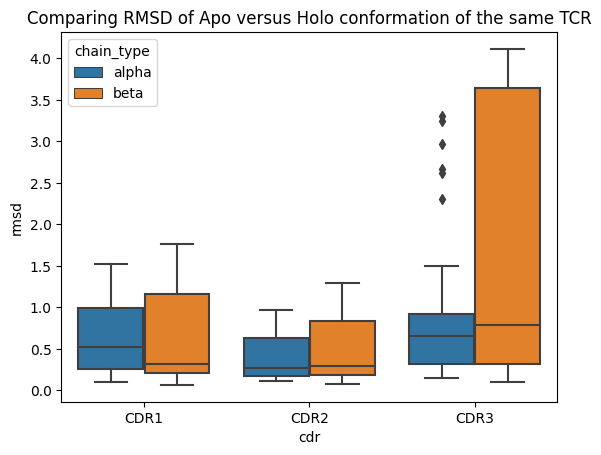

In [33]:
sns.boxplot(data=apo_holo, y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of Apo versus Holo conformation of the same TCR')

apo_holo.groupby(['cdr', 'chain_type'])['rmsd'].describe()

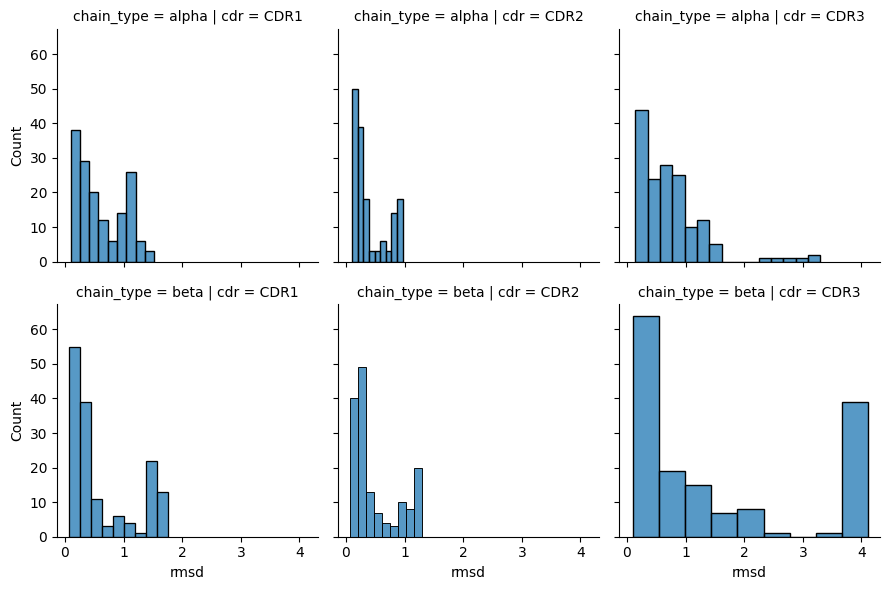

In [34]:
g = sns.FacetGrid(apo_holo, row='chain_type', col='cdr')
g.map(sns.histplot, 'rmsd')

The RMSD distributions are somewhat left skewed and don't look particularily normal.

<Axes: ylabel='count'>

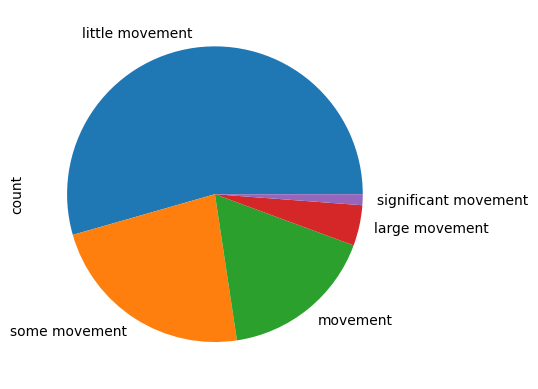

In [35]:
apo_holo['movement'].value_counts().plot.pie()

## Comparison of *apo*-*apo* and *holo*-*holo* to *apo*-*holo* (or vice versa) structures

The following analysis aims to ascertain whether there is notable movement in the CDR domains between the *apo* and *holo* conformations, using *apo*-*apo* and *holo*-*holo* differences as controls.

<Axes: xlabel='comparison', ylabel='rmsd'>

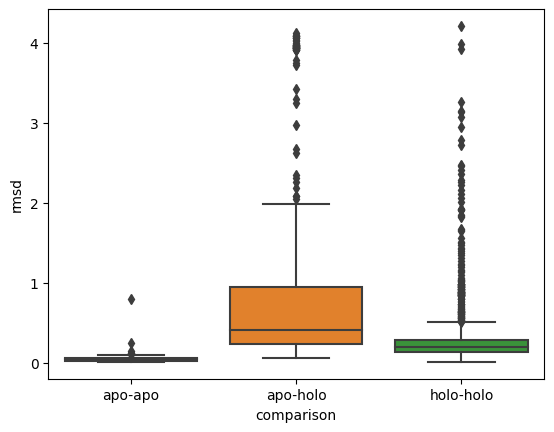

In [36]:
results['comparison'] = results['struct1_form'] + '-' + results['struct2_form']
results['comparison'] = results['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

sns.boxplot(results.sort_values('comparison'), x='comparison', y='rmsd')

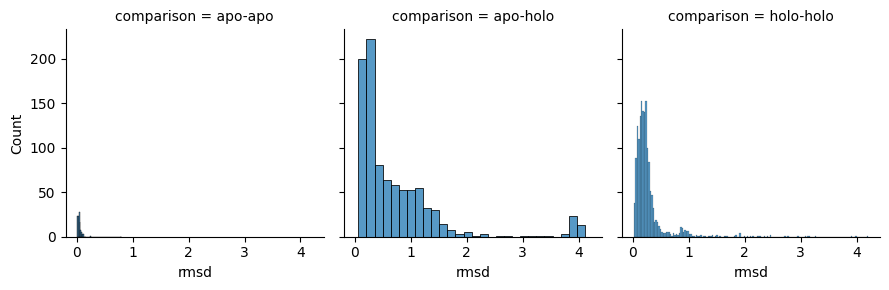

In [37]:
g = sns.FacetGrid(results.sort_values('comparison'), col='comparison')
g.map(sns.histplot, 'rmsd')

In [38]:
sample_apo_apo = results.query("comparison == 'apo-apo'")['rmsd'].to_numpy()
sample_apo_holo = results.query("comparison == 'apo-holo'")['rmsd'].to_numpy()
sample_holo_holo = results.query("comparison == 'holo-holo'")['rmsd'].to_numpy()

print(scipy.stats.kruskal(sample_apo_apo, sample_apo_holo, sample_holo_holo))

print('Post-hoc tests:')
combos = list(itertools.combinations([('apo-apo', sample_apo_apo), ('apo-holo', sample_apo_holo), ('holo-holo', sample_holo_holo)], 2))

significance_level = 0.05 / 3

statistics = []
p_vals = []

for (_, sample1), (_, sample2) in combos:
    stat, p_val = scipy.stats.ranksums(sample1, sample2)
    
    statistics.append(stat)
    p_vals.append(p_val)

pd.DataFrame({
    'sample 1': [name for (name, _), _ in combos],
    'sample 2': [name for _, (name, _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

KruskalResult(statistic=708.2608757314956, pvalue=1.5962648882463118e-154)
Post-hoc tests:


,sample 1,sample 2,statistic,p_val,significant
0,apo-apo,apo-holo,-17.030849,4.849563e-65,True
1,apo-apo,holo-holo,-15.820833,2.235170e-56,True
2,apo-holo,holo-holo,21.549993,5.295474e-103,True


The analysis of the plots and statistical tests shows that there is a statistically significant (p-value: 0.05) difference between the target and controls (as seen by the results of the Kruskal-Wallis test) but it also shows that there is a significant difference between the two controls.

## ... suspect that this is a popularity contest

That being said, based on the method in the first part of this analysis, more popular TCRs dominate the dataset and potentially cause some bias in results. Taking a look at the data, there are a few TCRs that have much higher abundance then others.

In [39]:
apo_holo['group'].value_counts()

group
SLNCTYSNSAFQYFMWYRQY-GPELLMYTYSSGNKEDGRFTAQV-ATYLCAMRGDSSYKLIFGSGTR-TLRCKPISGHDYLFWYRQT-GLELLIYFNNNVPIDDSGMPEDRFSAKM-AVYFCASSLWEKLAKNIQYFGAGTR        216
SLNCTYSDRGSQSFFWYRQY-SPELIMSIYSNGDKEDGRFTAQL-ATYLCAVTTDSWGKLQFGAGTQ-TLQCAQDMNHEYMSWYRQD-GLRLIHYSVGAGITDQGEVPNGYNVSR-SVYFCASRPGLAGGRPEQYFGPGTR         108
AFNCTYSNSASQSFFWYRQD-EPKLLMSVYSSGNEDGRFTAQL-ATYLCVVRAGKLIFGQGTE-TLLCAQDMNHEYMYWYRQD-GLRLIHYSVGEGTTAKGEVPDGYNVSR-SVYFCASGQGNFDIQYFGAGTR                 96
TVYCNSSSVFSSLQWYRQE-GPVLLVTVVTGGEVKKLKRLTFQF-GLYLCAGAGSQGNLIFGKGTK-TLSCEQNLNHDAMYWYRQD-GLRLIYYSQIVNDFQKGDIAEGYSVSR-AFYLCASSSRSSYEQYFGPGTR              90
SLNCTYSDRGSQSFFWYRQY-SPELIMFIYSNGDKEDGRFTAQL-ATYLCAVRTNSGYALNFGKGTS-TLRCSPKQGHDTVSWYQQA-GPQFIFQYYEEEERQRGNFPDRFSGHQ-ALYLCASSDTVSYEQYFGPGTR             72
SLNCTYSDRGSQSFFWYRQY-SPELIMFIYSNGDKEDGRFTAQL-ATYLCAVNFGGGKLIFGQGTE-TLRCTQDMRHNAMYWYRQD-GLRLIHYSNTAGTTGKGEVPDGYSVSR-SVYFCASSLSFGTEAFFGQGTR              48
NLPCNHSTISGNEYVYWYRQI-GPQYIIHGLKNNETNEMASLII-AVYYCIVWGGYQKVTFGTGTK-TFR

# Re-doing the calculations using average *apo* and *holo* comformation

To remove the effects of this bias, the following section used a different approach, taking the average position of the *apo* forms and comparing it to the average position of the *holo* forms. In this way, each TCR will have one corresponding RMSD measurement.

In [22]:
groups = []
cdrs = []
chain_types = []
rmsds = []

for group in os.listdir(export_path):
    apo_files = glob.glob(os.path.join(export_path, group,  '*apo.pdb'))
    holo_files = glob.glob(os.path.join(export_path, group,  '*holo.pdb'))
    
    num_apo_files = len(apo_files)
    num_holo_files = len(holo_files)
    
    apo_avg_cdr_1_alpha_coords = None
    apo_avg_cdr_2_alpha_coords = None
    apo_avg_cdr_3_alpha_coords = None
    apo_avg_cdr_1_beta_coords = None
    apo_avg_cdr_2_beta_coords = None
    apo_avg_cdr_3_beta_coords = None
    
    for path in apo_files:
        chains = get_chain_assignments(path)
        
        with open(path, 'r') as fh:
            structure_df = parse_pdb(fh.read(), silent=True).to_pandas()
            
        structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: chains[chain_id])
        structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
        structure_df['backbone'] = structure_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))

        struct_cdr_1_alpha_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_2_alpha_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_3_alpha_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone"))

        struct_cdr_1_beta_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_2_beta_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_3_beta_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone"))

        apo_avg_cdr_1_alpha_coords = struct_cdr_1_alpha_backbone if apo_avg_cdr_1_alpha_coords is None else apo_avg_cdr_1_alpha_coords + struct_cdr_1_alpha_backbone
        apo_avg_cdr_2_alpha_coords = struct_cdr_2_alpha_backbone if apo_avg_cdr_2_alpha_coords is None else apo_avg_cdr_2_alpha_coords + struct_cdr_2_alpha_backbone
        apo_avg_cdr_3_alpha_coords = struct_cdr_3_alpha_backbone if apo_avg_cdr_3_alpha_coords is None else apo_avg_cdr_3_alpha_coords + struct_cdr_3_alpha_backbone
        apo_avg_cdr_1_beta_coords = struct_cdr_1_beta_backbone if apo_avg_cdr_1_beta_coords is None else apo_avg_cdr_1_beta_coords + struct_cdr_1_beta_backbone
        apo_avg_cdr_2_beta_coords = struct_cdr_2_beta_backbone if apo_avg_cdr_2_beta_coords is None else apo_avg_cdr_2_beta_coords + struct_cdr_2_beta_backbone
        apo_avg_cdr_3_beta_coords = struct_cdr_3_beta_backbone if apo_avg_cdr_3_beta_coords is None else apo_avg_cdr_3_beta_coords + struct_cdr_3_beta_backbone
    
    apo_avg_cdr_1_alpha_coords /= num_apo_files
    apo_avg_cdr_2_alpha_coords /= num_apo_files
    apo_avg_cdr_3_alpha_coords /= num_apo_files
    apo_avg_cdr_1_beta_coords /= num_apo_files
    apo_avg_cdr_2_beta_coords /= num_apo_files
    apo_avg_cdr_3_beta_coords /= num_apo_files

    holo_avg_cdr_1_alpha_coords = None
    holo_avg_cdr_2_alpha_coords = None
    holo_avg_cdr_3_alpha_coords = None
    holo_avg_cdr_1_beta_coords = None
    holo_avg_cdr_2_beta_coords = None
    holo_avg_cdr_3_beta_coords = None
    
    for path in holo_files:
        chains = get_chain_assignments(path)
        
        with open(path, 'r') as fh:
            structure_df = parse_pdb(fh.read(), silent=True).to_pandas()
            
        structure_df['chain_type'] = structure_df['chain_id'].map(lambda chain_id: chains[chain_id])
        structure_df['cdr'] = structure_df['residue_seq_id'].map(assign_cdr_number)
        structure_df['backbone'] = structure_df['atom_name'].map(lambda atom_name: (atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'))

        struct_cdr_1_alpha_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_2_alpha_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'alpha_chain' and backbone"))
        struct_cdr_3_alpha_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'alpha_chain' and backbone"))

        struct_cdr_1_beta_backbone = get_coords(structure_df.query("cdr == 1 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_2_beta_backbone = get_coords(structure_df.query("cdr == 2 and chain_type == 'beta_chain' and backbone"))
        struct_cdr_3_beta_backbone = get_coords(structure_df.query("cdr == 3 and chain_type == 'beta_chain' and backbone"))

        holo_avg_cdr_1_alpha_coords = struct_cdr_1_alpha_backbone if holo_avg_cdr_1_alpha_coords is None else holo_avg_cdr_1_alpha_coords + struct_cdr_1_alpha_backbone
        holo_avg_cdr_2_alpha_coords = struct_cdr_2_alpha_backbone if holo_avg_cdr_2_alpha_coords is None else holo_avg_cdr_2_alpha_coords + struct_cdr_2_alpha_backbone
        holo_avg_cdr_3_alpha_coords = struct_cdr_3_alpha_backbone if holo_avg_cdr_3_alpha_coords is None else holo_avg_cdr_3_alpha_coords + struct_cdr_3_alpha_backbone
        holo_avg_cdr_1_beta_coords = struct_cdr_1_beta_backbone if holo_avg_cdr_1_beta_coords is None else holo_avg_cdr_1_beta_coords + struct_cdr_1_beta_backbone
        holo_avg_cdr_2_beta_coords = struct_cdr_2_beta_backbone if holo_avg_cdr_2_beta_coords is None else holo_avg_cdr_2_beta_coords + struct_cdr_2_beta_backbone
        holo_avg_cdr_3_beta_coords = struct_cdr_3_beta_backbone if holo_avg_cdr_3_beta_coords is None else holo_avg_cdr_3_beta_coords + struct_cdr_3_beta_backbone
    
    holo_avg_cdr_1_alpha_coords /= num_holo_files
    holo_avg_cdr_2_alpha_coords /= num_holo_files
    holo_avg_cdr_3_alpha_coords /= num_holo_files
    holo_avg_cdr_1_beta_coords /= num_holo_files
    holo_avg_cdr_2_beta_coords /= num_holo_files
    holo_avg_cdr_3_beta_coords /= num_holo_files
    
    for _ in range(6):
        groups.append(group)

    for _ in range(3):
        chain_types.append('alpha')

    cdrs.append('CDR1')
    rmsds.append(rmsd(apo_avg_cdr_1_alpha_coords, holo_avg_cdr_1_alpha_coords))
    cdrs.append('CDR2')
    rmsds.append(rmsd(apo_avg_cdr_2_alpha_coords, holo_avg_cdr_2_alpha_coords))
    cdrs.append('CDR3')
    rmsds.append(rmsd(apo_avg_cdr_3_alpha_coords, holo_avg_cdr_3_alpha_coords))

    for _ in range(3):
        chain_types.append('beta')

    cdrs.append('CDR1')
    rmsds.append(rmsd(apo_avg_cdr_1_beta_coords, holo_avg_cdr_1_beta_coords))
    cdrs.append('CDR2')
    rmsds.append(rmsd(apo_avg_cdr_2_beta_coords, holo_avg_cdr_2_beta_coords))
    cdrs.append('CDR3')
    rmsds.append(rmsd(apo_avg_cdr_3_beta_coords, holo_avg_cdr_3_beta_coords))

In [23]:
results_avg = pd.DataFrame(zip(groups, chain_types, cdrs, rmsds), columns=['group', 'chain_type', 'cdr', 'rmsd'])
results_avg

,group,chain_type,cdr,rmsd
0,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,alpha,CDR1,1.220229
1,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,alpha,CDR2,0.865866
2,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,alpha,CDR3,2.751492
3,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,beta,CDR1,0.414487
4,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,beta,CDR2,0.957903
...,...,...,...,...
133,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,alpha,CDR2,0.859473
134,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,alpha,CDR3,0.863497
135,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,beta,CDR1,0.583921
136,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,beta,CDR2,0.318365


<Axes: ylabel='count'>

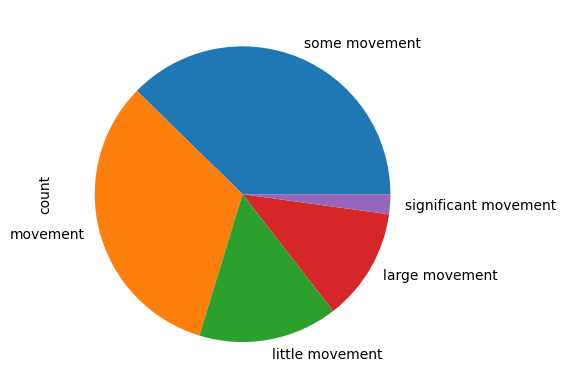

In [61]:
results_avg['movement'] = results_avg['rmsd'].map(categorize_movement)

results_avg['movement'].value_counts().plot.pie()

count      mean       std       min       25%       50%   
cdr  chain_type                                                            
CDR1 alpha        23.0  1.277489  0.674670  0.301591  0.708597  1.253725  \
     beta         23.0  0.743259  0.339884  0.243955  0.499633  0.745737   
CDR2 alpha        23.0  1.156865  0.652022  0.462977  0.761026  1.000609   
     beta         23.0  0.811468  0.735823  0.318365  0.469681  0.613337   
CDR3 alpha        23.0  2.011033  1.218452  0.241158  1.052842  1.645011   
     beta         23.0  1.235394  0.864757  0.159922  0.672891  0.943577   

                      75%       max  
cdr  chain_type                      
CDR1 alpha       1.707544  2.741159  
     beta        0.938867  1.415011  
CDR2 alpha       1.232155  3.045568  
     beta        0.922519  3.904451  
CDR3 alpha       2.823427  4.561604  
     beta        1.574188  3.364126

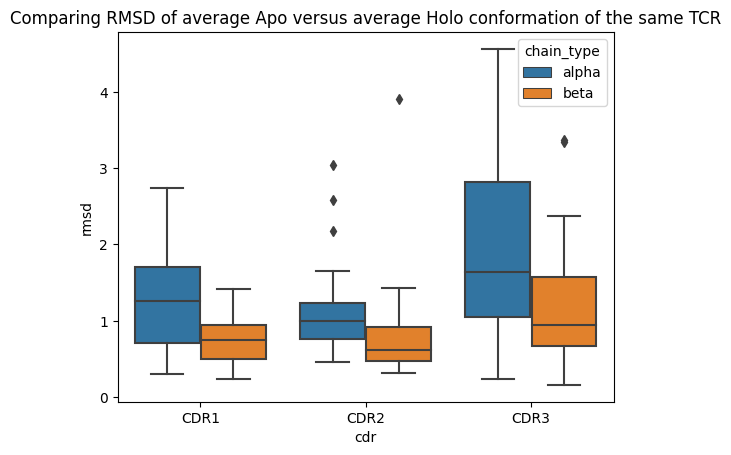

In [24]:
sns.boxplot(data=results_avg, y='rmsd', x='cdr', hue='chain_type')
plt.title('Comparing RMSD of average Apo versus average Holo conformation of the same TCR')

results_avg.groupby(['cdr', 'chain_type'])['rmsd'].describe()

The plots seem to show the same trend as before which is reassuring.

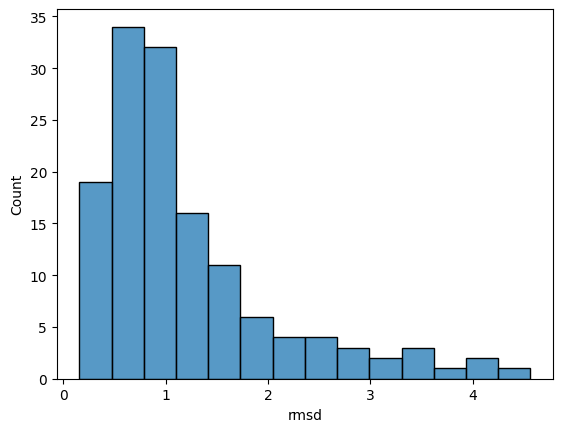

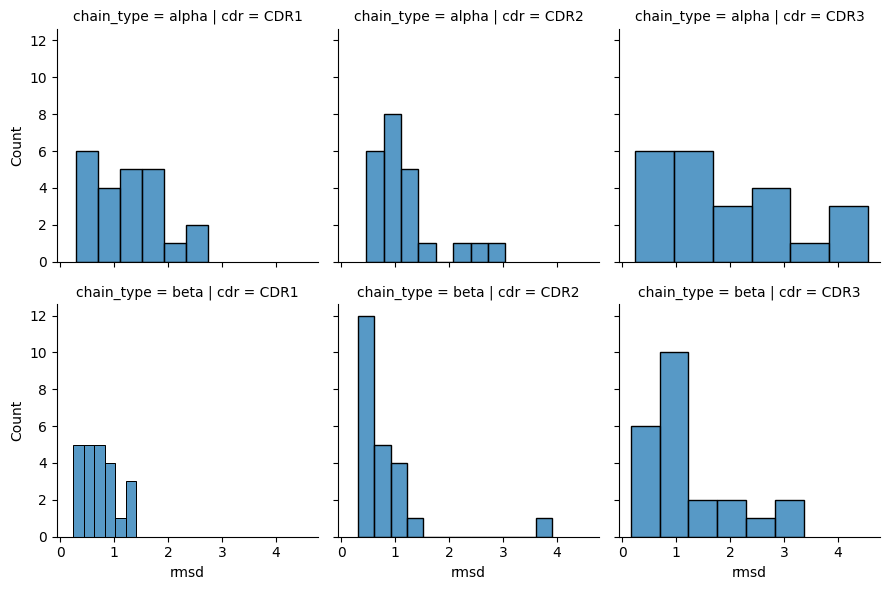

In [25]:
sns.histplot(results_avg, x='rmsd')

g = sns.FacetGrid(results_avg, row='chain_type', col='cdr')
g.map(sns.histplot, 'rmsd')

In [26]:
factors = list(itertools.product(('alpha', 'beta'), ('CDR1', 'CDR2', 'CDR3')))
samples = []
for chain, cdr in factors:
    samples.append(results_avg.query('chain_type == @chain and cdr == @cdr')['rmsd'].to_numpy())

print(scipy.stats.kruskal(*samples))    

print('\n\nPost hoc analysis')
combos = list(itertools.combinations(factors, 2))
significance_level = 0.05 / len(combos)

p_values = []
statistics = []

for (chain_x, cdr_x), (chain_y, cdr_y) in combos:
    sample_x = results_avg.query('chain_type == @chain_x and cdr == @cdr_x')
    sample_x = sample_x.sort_values('group')
    
    sample_y = results_avg.query('chain_type == @chain_y and cdr == @cdr_y')
    sample_y = sample_y.sort_values('group')
    
    statistic, p_value = scipy.stats.wilcoxon(sample_x['rmsd'].to_numpy(), sample_y['rmsd'].to_numpy())
    
    statistics.append(statistic)
    p_values.append(p_value)

results_avg_stats = pd.DataFrame({
    'sample 1': [f"{cdr}{chain}" for (chain, cdr), _ in combos],
    'sample 2': [f"{cdr}{chain}" for _, (chain, cdr) in combos],
    'statistics': statistics,
    'p_val': p_values,
})
results_avg_stats['significant'] = results_avg_stats['p_val'].map(lambda p_val: p_val < significance_level)

results_avg_stats

KruskalResult(statistic=30.366172090682824, pvalue=1.2492090422630644e-05)


Post hoc analysis


,sample 1,sample 2,statistics,p_val,significant
0,CDR1alpha,CDR2alpha,104.0,0.314554,False
1,CDR1alpha,CDR3alpha,60.0,0.016311,False
2,CDR1alpha,CDR1beta,50.0,0.006033,False
3,CDR1alpha,CDR2beta,50.0,0.006033,False
4,CDR1alpha,CDR3beta,122.0,0.643390,False
5,CDR2alpha,CDR3alpha,49.0,0.005414,False
6,CDR2alpha,CDR1beta,57.0,0.012295,False
7,CDR2alpha,CDR2beta,49.0,0.005414,False
8,CDR2alpha,CDR3beta,137.0,0.988101,False
9,CDR3alpha,CDR1beta,6.0,0.000003,True


The statistical tests show that there is some significant differences in these results.